# Module 1: Introduction to Deep Learning in Oil & Gas

It teaches foundational deep learning ideas in an oil & gas context with step-by-step runnable code and concise explanations.

What you'll learn:
- Shallow vs Deep Learning on a well production example
- Why Deep Learning in Oil & Gas (value and use-cases)
- How Deep Learning works (brief)
- How learning differs from pure optimization (gradient descent visual)
- Data challenges with a synthetic seismic demo + augmentations

All sample inputs are read from JSON files in `Module 1/data/` so you can swap in real data easily.

## Setup: Environment and Packages
Run once. If packages are already available (e.g., in a venv), installs are skipped.

In [18]:
import sys, subprocess, importlib

def pip_install(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for p in ['numpy','pandas','matplotlib','scikit-learn','torch']:
    pip_install(p)
print('Package check complete.')

Installing scikit-learn...
Package check complete.


In [19]:
# ArivuAI-inspired plot style (palette/typography inferred)
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (6.0, 4.0)
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.edgecolor'] = '#4F4F4F'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#004E89','#3DA5D9','#F1A208','#4F4F4F'])
print('Applied ArivuAI-inspired plot style.')

Applied ArivuAI-inspired plot style.


## 1) Background & Why This Matters
- Oil & Gas decisions rely on multi-physics data (wells, logs, seismic, production).
- Shallow ML (linear models, trees) often needs careful feature engineering.
- Deep Learning can learn nonlinear, hierarchical features from raw or lightly processed data, enabling better generalization and automation.

Inline figures from 'Azure and ML in Oil and Gas Industry.pptx' may be added to complement these points.

## 2) Shallow vs Deep Learning (Hands-on)
We start with a small illustrative well dataset (from JSON) and compare:
- Linear Regression
- Random Forest (shallow ensemble)
- Simple PyTorch MLP (deep)

We keep runs deterministic and capped to a few seconds; models are saved for reproducibility.

In [20]:
# Robust data path detection (works regardless of where kernel starts)
from pathlib import Path
print('CWD =', Path.cwd())
candidates = [Path.cwd() / 'Module 1' / 'data', Path.cwd() / 'data']
DATA_DIR = next((p for p in candidates if p.is_dir()), None)
if DATA_DIR is None:
    for parent in [Path.cwd()] + list(Path.cwd().parents):
        p = parent / 'Module 1' / 'data'
        if p.is_dir():
            DATA_DIR = p
            break
if DATA_DIR is None:
    raise FileNotFoundError("Could not locate 'Module 1/data'. Set DATA_DIR manually.")
print('Using DATA_DIR =', DATA_DIR)
try:
    items = [x.name for x in list(DATA_DIR.iterdir())[:10]]
    print('DATA_DIR contents (first 10):', items)
except Exception as e:
    print('Could not list DATA_DIR:', e)

CWD = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 1
Using DATA_DIR = d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 1\data
DATA_DIR contents (first 10): ['dnn_synthetic_params.json', 'exported_slides', 'model_lr.pkl', 'model_mlp.pkl', 'model_mlp.pt', 'model_rf.pkl', 'seismic_params.json', 'well_data.json']


Linear Regression R2: 1.0
Random Forest R2: 0.954
PyTorch MLP R2: 1.0


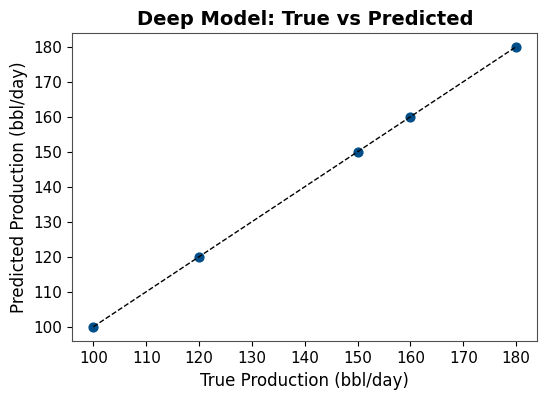

Saved models to data folder.


In [21]:
import os, json, time, numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

# Use resolved pathlib DATA_DIR from the previous cell
with (DATA_DIR / 'well_data.json').open() as f:
    wd = json.load(f)
df = pd.DataFrame(wd)
X = df[['reservoir_pressure','temperature','porosity','permeability']].values
y = df['production'].values

# Shallow models
lr = LinearRegression().fit(X, y)
rf = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=0).fit(X, y)
print('Linear Regression R2:', round(lr.score(X,y),3))
print('Random Forest R2:', round(rf.score(X,y),3))

# Deep model (PyTorch MLP)
np.random.seed(0); torch.manual_seed(0)
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X).astype('float32')
ys = y.astype('float32')
model = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,16), nn.ReLU(), nn.Linear(16,1))
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
X_t = torch.tensor(Xs)
y_t = torch.tensor(ys).view(-1,1)

TRAIN_SECONDS = 3.0
start = time.time()
for epoch in range(2000):
    opt.zero_grad()
    pred = model(X_t)
    loss = loss_fn(pred, y_t)
    loss.backward()
    opt.step()
    if (time.time() - start) > TRAIN_SECONDS:
        break
r2 = r2_score(ys, model(X_t).detach().numpy())
print('PyTorch MLP R2:', round(r2,3))

# Save models for reproducibility
import pickle
with open(os.path.join(DATA_DIR,'model_lr.pkl'),'wb') as f: pickle.dump(lr,f)
with open(os.path.join(DATA_DIR,'model_rf.pkl'),'wb') as f: pickle.dump(rf,f)
torch.save(model.state_dict(), os.path.join(DATA_DIR,'model_mlp.pt'))
with open(os.path.join(DATA_DIR,'model_mlp.pkl'),'wb') as f: pickle.dump({'state_dict': model.state_dict(), 'arch': [4,32,16,1]}, f)

# Quick visual: Pred vs True (deep model)
plt.figure()
plt.scatter(y, model(X_t).detach().numpy().ravel(), s=40)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
plt.xlabel('True Production (bbl/day)')
plt.ylabel('Predicted Production (bbl/day)')
plt.title('Deep Model: True vs Predicted')
plt.show()
print('Saved models to data folder.')

Figure: Deep model prediction quality — Points closer to the dashed line indicate better fit.
Takeaway: On tiny data, all models can fit; deep models shine as data and complexity grow.

## 3) How Deep Learning Works (Brief)
- Standardize inputs for stable optimization.
- Stack linear layers + nonlinear activations (e.g., ReLU).
- Define a loss (e.g., MSE) and optimize (e.g., Adam).
- Control overfitting with regularization (dropout, weight decay) and validation splits.

## 4) Learning vs Pure Optimization (Brief Visual)
Learning targets generalization to unseen data; optimization targets minimizing training loss.
Below: gradient descent path on a simple 2D loss surface.

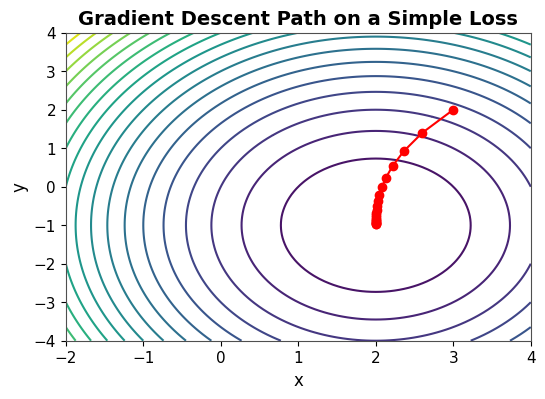

In [22]:
import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)
def f(x,y): return (x-2)**2 + 0.5*(y+1)**2
def grad(x,y): return np.array([2*(x-2), 1*(y+1)])
xy = np.array([3.0, 2.0])
lr=0.2
path=[xy.copy()]
for _ in range(20):
    xy -= lr*grad(*xy)
    path.append(xy.copy())
path=np.array(path)
X,Y = np.meshgrid(np.linspace(-2,4,100), np.linspace(-4,4,100))
Z=f(X,Y)
plt.figure()
plt.contour(X,Y,Z, levels=20)
plt.plot(path[:,0], path[:,1], 'ro-')
plt.title('Gradient Descent Path on a Simple Loss')
plt.xlabel('x'); plt.ylabel('y'); plt.show()

Figure: GD steps move along steepest descent; learning also requires validation and regularization to avoid overfitting.

## 5) Seismic Demo and Challenges
We synthesize a simple layered velocity model, compute reflection coefficients, convolve with a Ricker wavelet, and visualize a seismic section.
Then we show simple augmentations (noise, shift, amplitude scaling) used to expand limited labeled data and improve robustness.

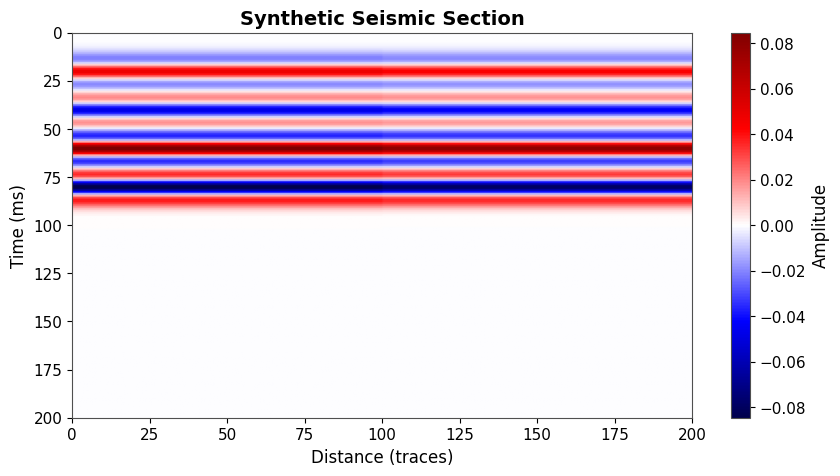

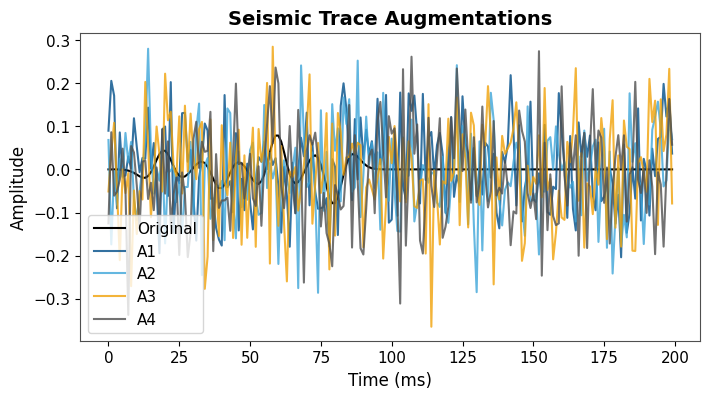

In [23]:
import json, numpy as np, matplotlib.pyplot as plt
with (DATA_DIR / 'seismic_params.json').open() as f:
    sp = json.load(f)
nx, nz = sp['nx'], sp['nz']
velocity = np.ones((nz, nx))*2000
for layer in sp['layers']:
    velocity[layer['z_start']:layer['z_end'], :] += layer['delta_velocity']
velocity[:, sp['fault_step_col']:] += sp['fault_delta_velocity']
rc = np.diff(velocity, axis=0)/(velocity[:-1]+velocity[1:])
dt, t_max = sp['dt'], sp['t_max']
t = np.arange(0, t_max, dt)
def ricker(points, a):
    tt = np.linspace(-points//2, points//2, points)
    A = 2/(np.sqrt(3*a)*(np.pi**0.25))
    wsq = a**2
    return A*(1-(tt**2)/wsq)*np.exp(-(tt**2)/(2*wsq))
w = ricker(len(t), sp['wavelet_a'])
seis = np.zeros((len(t), nx))
for i in range(nx):
    tr = np.zeros(len(t))
    tr[:rc.shape[0]] = rc[:,i]
    seis[:,i] = np.convolve(tr, w, mode='same')
plt.figure(figsize=(10,5))
plt.imshow(seis, aspect='auto', cmap='seismic', extent=[0,nx, t_max*1000, 0])
plt.colorbar(label='Amplitude')
plt.xlabel('Distance (traces)'); plt.ylabel('Time (ms)');
plt.title('Synthetic Seismic Section'); plt.show()

# Augmentations
def add_noise(trace, noise_level=0.1):
    return trace + np.random.normal(0, noise_level, len(trace))
def time_shift(trace, max_shift=5):
    return np.roll(trace, np.random.randint(-max_shift, max_shift))
def amp_scale(trace, lo=0.8, hi=1.2):
    return trace*np.random.uniform(lo,hi)
orig = seis[:, nx//2]
aug = [amp_scale(time_shift(add_noise(orig))) for _ in range(4)]
plt.figure(figsize=(8,4))
plt.plot(t*1000, orig, 'k-', label='Original')
for i, tr in enumerate(aug): plt.plot(t*1000, tr, label=f'A{i+1}', alpha=0.8)
plt.xlabel('Time (ms)'); plt.ylabel('Amplitude'); plt.title('Seismic Trace Augmentations'); plt.legend(); plt.show()

Figures: (Top) synthetic seismic section with layers and a lateral change; (Bottom) trace augmentations (noise/shift/scale).
Takeaway: Oil & Gas datasets are often noisy and label-limited — augmentations and domain priors help generalization.

## 6) Load Saved Models (Optional)
Reload previously trained models to avoid retraining during demos.

In [24]:
import pickle, torch
from pathlib import Path
# Use DATA_DIR from earlier; if missing, detect like above
try:
    DATA_DIR
except NameError:
    candidates = [Path.cwd() / 'Module 1' / 'data', Path.cwd() / 'data']
    DATA_DIR = next((p for p in candidates if p.is_dir()), None)
    if DATA_DIR is None:
        for parent in [Path.cwd()] + list(Path.cwd().parents):
            p = parent / 'Module 1' / 'data'
            if p.is_dir():
                DATA_DIR = p
                break
    if DATA_DIR is None:
        raise FileNotFoundError("Could not locate 'Module 1/data'. Set DATA_DIR manually.")
with (DATA_DIR / 'model_lr.pkl').open('rb') as f: lr_loaded = pickle.load(f)
with (DATA_DIR / 'model_rf.pkl').open('rb') as f: rf_loaded = pickle.load(f)
state = torch.load(str(DATA_DIR / 'model_mlp.pt'), map_location='cpu')
from torch import nn
mlp_loaded = nn.Sequential(nn.Linear(4,32), nn.ReLU(), nn.Linear(32,16), nn.ReLU(), nn.Linear(16,1))
mlp_loaded.load_state_dict(state)
print('Loaded LR, RF, and MLP models from', DATA_DIR)

Loaded LR, RF, and MLP models from d:\Suni Files\AI Code Base\Oil and Gas\Oil and Gas Pruthvi College Course Material\Module 1\data


## 7) Summary
- Shallow vs Deep illustrated on a small well dataset.
- Optimization vs learning clarified with a gradient descent visual.
- Seismic generation + augmentations reveal data challenges in Oil & Gas.

Next: swap JSONs with your real data and re-run. Consider adding validation splits, dropout, and larger synthetic datasets for more realistic training curves.